# Heat conduction through a wall

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from glob import glob

from scipy.integrate import odeint

In [2]:
def projection(sigma_deg, phi_C_deg, phi_S_deg, beta_deg):
    """ Calcul des coefficient de projection
        pour une surface ayant une certaine orientation

        ref.: http://www.a-ghadimi.com/files/Courses/Renewable%20Energy/REN_Book.pdf
        book "Renewable and Efficient Electric Power Systems", Gilbert M. Masters, 2004
        page 414

        sigma:  angle de la surface avec l'horizontal, deg
        phi_C: azimuth de la surface, deg (relative to south)
         Azimuth angles are positive in the southeastdirection and are negative in the southwest

        phi_S: azimuth du soleil, deg
        beta: altitude du soleil, deg
    """

    # conversion en radian: 
    sigma = sigma_deg *np.pi/180
    phi_C = phi_C_deg *np.pi/180

    beta = beta_deg *np.pi/180  # rad
    phi_S = phi_S_deg *np.pi/180  # rad

    cosTheta = np.cos(beta)*np.cos( phi_S - phi_C )*np.sin( sigma ) \
               + np.cos( sigma )*np.sin( beta )

    cosTheta[cosTheta < 0] = 0

    diffuse = (1 + np.cos(sigma))/2
    
    return cosTheta, diffuse

In [3]:
filelist = glob('./data/*.pck')
for k, path in enumerate(filelist):
    print(k, path)

0 ./data/weatherdata_2019-07-11_10days.pck
1 ./data/weatherdata_2019-05-01_120days.pck
2 ./data/weatherdata.pck
3 ./data/weatherdata_2019-01-05_4days.pck
4 ./data/weatherdata_2019-08-11_10days.pck
5 ./data/weatherdata_2019-03-15_28days.pck
6 ./data/sundata.pck


In [4]:
k = 4
weatherdata = pd.read_pickle(filelist[k])

In [5]:
cloudCover = weatherdata['cloudCover']
# Kasten Czeplack model
weatherdata['dni_cloud'] = weatherdata['dni']*( 1 - 0.75*cloudCover**( 3.4 ) )
weatherdata['dhi_cloud'] =  weatherdata['dhi']*( .3 + .65*(cloudCover)**2 )

In [6]:
phi_S_deg = -weatherdata['azimuth'].values + 180
beta_deg  =  weatherdata['apparent_elevation'].values

In [7]:
sigma_deg = 90  # surface tilt
phi_C_deg = 0  # surface azimuth from south, positve toward east

In [8]:
costheta, diff = projection(sigma_deg, phi_C_deg, phi_S_deg, beta_deg)

direct_irrad = costheta * weatherdata['dni_cloud']
diffuse_irrad = diff * weatherdata['dhi_cloud']
irrad_tot = direct_irrad + diffuse_irrad

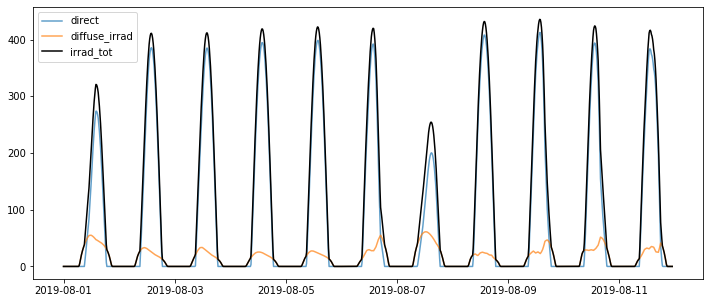

In [10]:
plt.figure(figsize=(12, 5));
#plt.plot(weatherdata.index, phi_S_deg, label='phi sun')
plt.plot(weatherdata.index, direct_irrad, label='direct', alpha=.7)
plt.plot(weatherdata.index, diffuse_irrad, label='diffuse_irrad', alpha=.7)
plt.plot(weatherdata.index, irrad_tot, label='irrad_tot', color='black')

plt.legend();

In [11]:
# Convert to array
time = weatherdata.index.astype(np.int64) // 10**9 # in seconds
time = time - time[0]

T_ext = weatherdata['temperature'].values

phi_sun = irrad_tot.values

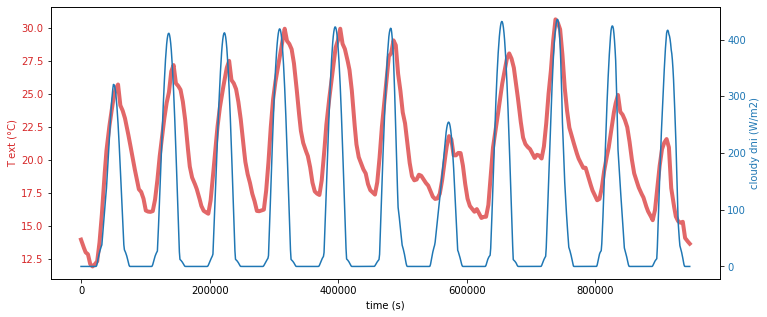

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('T ext (°C)', color=color)
ax1.plot(time, T_ext, color=color, linewidth=4, alpha=.7)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cloudy dni (W/m2)', color=color)  # we already handled the x-label with ax1
ax2.plot(time, phi_sun, color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [13]:
from scipy.interpolate import interp1d
#(x, y, kind='linear', axis=-1, c

In [14]:
temperature_ext = interp1d(time, T_ext)
solar_flux_surface = interp1d(time, phi_sun)

In [15]:
materials = {}

# in SI:
materials['concrete']  = {'k':1.8, 'rho':2300, 'Cp':1000}
materials['wood_wool'] = {'k':0.04, 'rho':160, 'Cp':2100}
materials['PSE'] = {'k':0.04, 'rho':34, 'Cp':145}
materials['clay'] = {'k':1.28, 'rho':880, 'Cp':1450}

# Compute Thermal diffusivity : 
for props in materials.values():
    if 'kappa' not in props:
        props['kappa'] = props['k']/props['rho']/props['Cp']

In [16]:
print(materials.keys())

dict_keys(['concrete', 'wood_wool', 'PSE', 'clay'])


In [56]:
mat = materials['wood_wool']
kappa = mat['kappa']
rhoCp = mat['rho']*mat['Cp']

dt = 60 * 5 # second
delta_x = np.sqrt( dt*kappa )
print('delta_x', delta_x)

R = 3

wall_thickness = R * mat['k']   # m, wall thickness
print(wall_thickness)

h = 10  # W/m2/K
# convection libre air 5-25

delta_x 0.005976143046671968
0.12


In [57]:
# Solve
N = 21  # number of mesh points

X = np.linspace( 0, wall_thickness, N )  # mesh

dx = wall_thickness/(N-1)

print('dx', dx)
Tzero = np.ones_like( X )* 30
#Tzero = 1+Tzero

dx 0.006


In [48]:
from numba import jit, float64

In [49]:
@jit
def inside_dTdt(T, T_ext, flux):
    dTdt = np.zeros_like( T )
    dTdt[0] = (flux + h*(T_ext - T[0]))/(rhoCp*dx)
    dTdt[0] += kappa*(T[1] - T[0])/dx
    
    T_i = T[1:-1]
    T_im1 = T[0:-2]  # i minus one
    T_ip1 = T[2:]    # i plus one

    dTdt[1:-1] += kappa*( T_ip1 + T_im1 -2*T_i )/dx**2

    # Boundary conditions:
    dTdt[-1] = dTdt[-2]
    return dTdt

In [50]:
def dTdt(T, t):
    
    
    T_ext_t = np.interp(t, time, T_ext)  
    phi = np.interp(t, time, phi_sun)  
    
    return inside_dTdt(T, T_ext_t, phi)

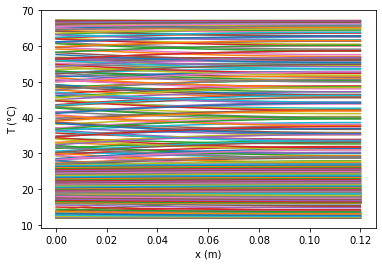

In [51]:
days =  3600 * 24 # s
t_span = np.linspace(0, 3*days, 3*136)

results = odeint(dTdt, Tzero, t_span)

plt.plot( X, results.T ); plt.xlabel('x (m)');
plt.ylabel('T (°C)');

In [52]:
t_span_hour = t_span / 3600

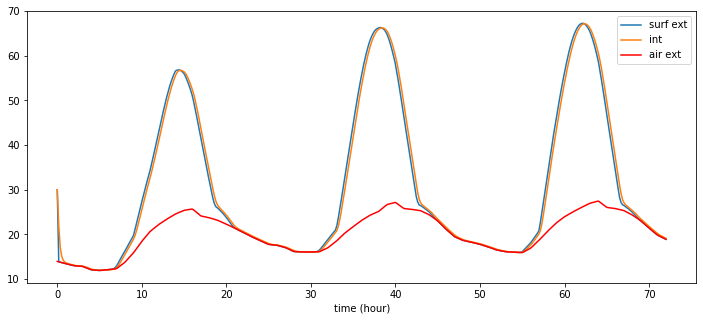

In [53]:
plt.figure(figsize=(12, 5))

plt.plot(t_span_hour, results.T[0, :], label='surf ext')
plt.plot(t_span_hour, results.T[-1, :], label='int')

plt.plot(t_span_hour, temperature_ext(t_span), color='red', label='air ext');
plt.xlabel('time (hour)'); plt.legend();

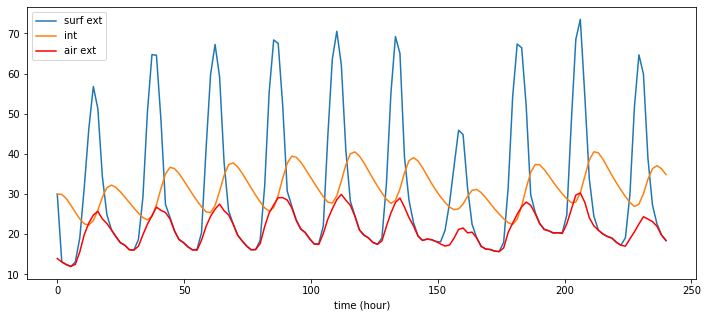

In [415]:
plt.figure(figsize=(12, 5))

plt.plot(t_span_hour, results.T[0, :], label='surf ext')
plt.plot(t_span_hour, results.T[-1, :], label='int')

plt.plot(t_span_hour, temperature_ext(t_span), color='red', label='air ext');
plt.xlabel('time (hour)'); plt.legend();
